# Parking with Hindsight Experience Replay

##  Warming up
We start with a few useful installs and imports:

In [18]:
# #@title Install environment and agent
# !pip install highway-env
# # TODO: we use the bleeding edge version because the current stable version does not support the latest gym>=0.21 versions. Revert back to stable at the next SB3 release.
# !pip install git+https://github.com/DLR-RM/stable-baselines3

# Environment
import gymnasium as gym
import highway_env

# Agent
from stable_baselines3 import HerReplayBuffer, SAC

In [19]:
#@title Import helpers for visualization of episodes
import sys
from tqdm.notebook import trange
from tqdm import trange
# !pip install tensorboardx gym pyvirtualdisplay
# !apt-get install -y xvfb ffmpeg
# !git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/home/aayush_wsl/cs269_rl_parking/CS269-Parking/scripts')
from utils import record_videos, show_videos

In [21]:
#@title Tensorboard - click the refresh button once training is running

%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
#@title Training

LEARNING_STEPS = 5e4 # @param {type: "number"}

env = gym.make('parking-v0')
her_kwargs = dict(n_sampled_goal=4, goal_selection_strategy='future')
model = SAC('MultiInputPolicy', env, replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=her_kwargs, verbose=1, 
            tensorboard_log="logs", 
            buffer_size=int(1e6),
            learning_rate=1e-3,
            gamma=0.95, batch_size=1024, tau=0.05,
            policy_kwargs=dict(net_arch=[512, 512, 512]))

model.learn(int(LEARNING_STEPS))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 82.5     |
|    ep_rew_mean     | -48.2    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4        |
|    time_elapsed    | 77       |
|    total_timesteps | 330      |
| train/             |          |
|    actor_loss      | -8.51    |
|    critic_loss     | 0.494    |
|    ent_coef        | 0.797    |
|    ent_coef_loss   | -0.755   |
|    learning_rate   | 0.001    |
|    n_updates       | 229      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 63.4     |
|    ep_rew_mean     | -37.1    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 3        |


In [27]:
#@title Visualize a few episodes
import numpy as np
parking_config = {
    # Observation configuration
    "observation": {
        "type": "KinematicsGoal",
        "features": ["x", "y", "vx", "vy", "cos_h", "sin_h"],
        "scales": [100, 100, 1, 1, 1, 1],
        "normalize": False,
    },
    
    # Action configuration
    "action": {
        "type": "ContinuousAction",
        "acceleration_range": (-0.4, 0.4),
        # "steering_range": np.deg2rad(60),
        "speed_range": (-1.5, 1.5),
    },
    
    # Reward parameters
    "reward_weights": [10, 20, 1, 1, 5, 5],  # Weights for [x, y, vx, vy, cos_h, sin_h]
    "success_goal_reward": 0.12,
    "collision_reward": -5,
    
    # Vehicle control parameters
    "steering_range": np.deg2rad(20),  # Maximum steering angle in radians
    
    # Simulation parameters
    "simulation_frequency": 15,  # Hz
    "policy_frequency": 5,       # Hz
    "duration": 50,             # Maximum episode duration in steps
    
    # Rendering parameters
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    # "show_trajectories": True,
    
    # Environment setup
    "controlled_vehicles": 1,    # Number of vehicles to control
    "vehicles_count": 26,        # Number of parked vehicles (obstacles)
    "add_walls": True,           # Whether to add boundary walls

    # Additional parameters from AbstractEnv
    # "offscreen_rendering": False,
    # "manual_control": False,
    # "real_time_rendering": False,
}

N_EPISODES = 1 # @param {type: "integer"}

# Storage for trajectory data
trajectory_data = {
    'time': [],
    'x': [],
    'y': [],
    'vx': [],
    'vy': [],
    'heading': [],
    'cos_h': [],
    'sin_h': [],
    'goal_x': [],
    'goal_y': [],
    'episode': [],
    'reward': [],
    'action_accel': [],
    'action_steer': []
}

current_episode = 0
time_step = 0

env = gym.make('parking-v0', render_mode='rgb_array', config=parking_config)
env = record_videos(env)
for episode in trange(N_EPISODES, desc="Test episodes"):
    obs, info = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        
        # Store current state
        trajectory_data['time'].append(time_step)
        trajectory_data['x'].append(obs["observation"][0])
        trajectory_data['y'].append(obs["observation"][1])
        trajectory_data['vx'].append(obs["observation"][2])
        trajectory_data['vy'].append(obs["observation"][3])
        trajectory_data['cos_h'].append(obs["observation"][4])
        trajectory_data['sin_h'].append(obs["observation"][5])

        # Compute heading angle from cos_h and sin_h
        heading_rad = np.arctan2(obs["observation"][5], obs["observation"][4])
        trajectory_data['heading'].append(np.rad2deg(heading_rad))
        
        # Store goal
        trajectory_data['goal_x'].append(obs["desired_goal"][0])
        trajectory_data['goal_y'].append(obs["desired_goal"][1])
        
        # Store action (action is already a numpy array)
        trajectory_data['action_accel'].append(action[0])
        trajectory_data['action_steer'].append(action[1])
        
        trajectory_data['episode'].append(current_episode)

        # Step environment (action is already a numpy array)
        obs, reward, done, truncated, info = env.step(action)
        trajectory_data['reward'].append(reward)

        time_step += 1
        if done or truncated:
            obs, info = env.reset()
            current_episode += 1
            time_step = 0
env.close()
show_videos()

# ===== Convert to numpy arrays for plotting =====
for key in trajectory_data:
    trajectory_data[key] = np.array(trajectory_data[key])

print(f"\nTotal timesteps recorded: {len(trajectory_data['time'])}")
print(f"Episodes completed: {current_episode + 1}")

/home/aayush_wsl/.pyenv/versions/3.10.13/envs/parking-her-ppo/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/aayush_wsl/cs269_rl_parking/CS269-Parking/scripts/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Test episodes:   0%|          | 0/1 [00:00<?, ?it/s]

/home/aayush_wsl/.pyenv/versions/3.10.13/envs/parking-her-ppo/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:434: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
Test episodes: 100%|██████████| 1/1 [00:35<00:00, 35.13s/it]



Total timesteps recorded: 250
Episodes completed: 2


## Visualization Code

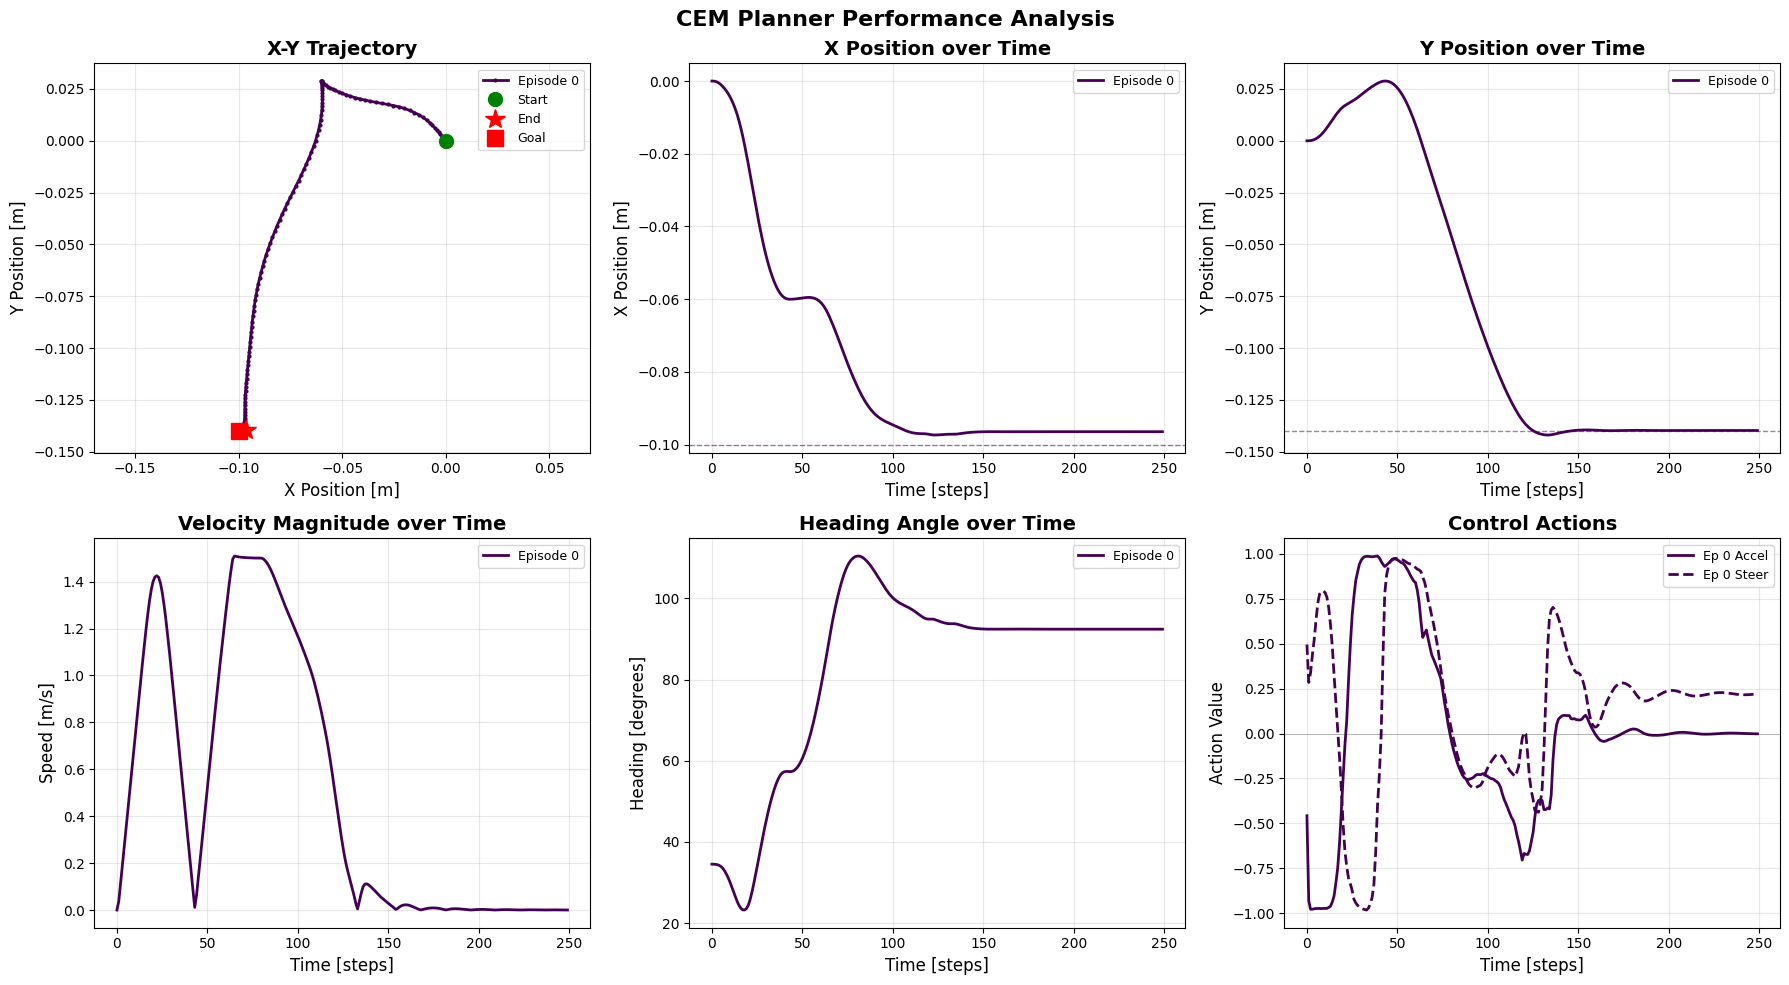

In [29]:
import matplotlib.pyplot as plt
#Fliping the y axis sign for position and velocity
trajectory_data['y'] = -trajectory_data['y']
trajectory_data['goal_y'] = -trajectory_data['goal_y']
trajectory_data['vy'] = -trajectory_data['vy']


# ===== PLOT 1: Position Trajectories (X-Y Plot) =====
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('CEM Planner Performance Analysis', fontsize=16, fontweight='bold')

# Get episode boundaries for coloring
episodes = trajectory_data['episode']
unique_episodes = np.unique(episodes)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_episodes)))

# Plot 1: X-Y Trajectory
ax = axes[0, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    ax.plot(trajectory_data['x'][mask], 
            trajectory_data['y'][mask], 
            color=colors[i], 
            label=f'Episode {int(ep)}',
            linewidth=2,
            marker='o',
            markersize=2)
    
    # Mark start and end
    ax.plot(trajectory_data['x'][mask][0], 
            trajectory_data['y'][mask][0], 
            'go', markersize=10, label='Start' if i == 0 else '')
    ax.plot(trajectory_data['x'][mask][-1], 
            trajectory_data['y'][mask][-1], 
            'r*', markersize=15, label='End' if i == 0 else '')
    
    # Mark goal
    ax.plot(trajectory_data['goal_x'][mask][0], 
            trajectory_data['goal_y'][mask][0], 
            'rs', markersize=12, label='Goal' if i == 0 else '')

ax.set_xlabel('X Position [m]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_title('X-Y Trajectory', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.axis('equal')

# Plot 2: X Position vs Time
ax = axes[0, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['x'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
    ax.axhline(y=trajectory_data['goal_x'][mask][0], 
               color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('X Position [m]', fontsize=12)
ax.set_title('X Position over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 3: Y Position vs Time
ax = axes[0, 2]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['y'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
    ax.axhline(y=trajectory_data['goal_y'][mask][0], 
               color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_title('Y Position over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 4: Velocity Magnitude
ax = axes[1, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    velocity = np.sqrt(trajectory_data['vx'][mask]**2 + trajectory_data['vy'][mask]**2)
    ax.plot(time_ep, velocity, 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Speed [m/s]', fontsize=12)
ax.set_title('Velocity Magnitude over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 5: Heading Angle
ax = axes[1, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['heading'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Heading [degrees]', fontsize=12)
ax.set_title('Heading Angle over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 6: Actions
ax = axes[1, 2]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['action_accel'][mask], 
            color=colors[i], linestyle='-', linewidth=2, 
            label=f'Ep {int(ep)} Accel' if i < 2 else '')
    ax.plot(time_ep, trajectory_data['action_steer'][mask], 
            color=colors[i], linestyle='--', linewidth=2, 
            label=f'Ep {int(ep)} Steer' if i < 2 else '')

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Action Value', fontsize=12)
ax.set_title('Control Actions', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

## Additional Detailed Plots

In [ ]:
# ===== PLOT 2: Velocity Components =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Velocity Analysis', fontsize=16, fontweight='bold')

# Vx over time
ax = axes[0, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['vx'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Vx [m/s]')
ax.set_title('X-Velocity')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Vy over time
ax = axes[0, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['vy'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Vy [m/s]')
ax.set_title('Y-Velocity')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Velocity phase plot (vx vs vy)
ax = axes[1, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    ax.plot(trajectory_data['vx'][mask], 
            trajectory_data['vy'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', 
            linewidth=2, marker='o', markersize=2)
ax.set_xlabel('Vx [m/s]')
ax.set_ylabel('Vy [m/s]')
ax.set_title('Velocity Phase Plot')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)

# Reward over time
ax = axes[1, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['reward'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Reward')
ax.set_title('Reward Signal')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()